### Spending Behaviour - Time Series Analysis

### Financial Analysis, Date Created - 28-10-2018

The purpose of this notebook is to gain an insight into the spending behaviour of Stuart Loxton and Sofia Ballesteros to then determine how to best improve spending behaviour. 

# Pocketbook
---

### Get transactional data from pocketbook

In [98]:
# import dependencies required to scrape data from pocketbook
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.firefox.firefox_profile import FirefoxProfile
import time
import os

In [99]:
class Pocketbook:
    def __init__(self):
        profile = FirefoxProfile()
        profile.set_preference("browser.download.folderList", 2)
        profile.set_preference("browser.download.manager.showWhenStarting", False)
        profile.set_preference("browser.download.dir", os.path.join(os.getcwd(), "data/"))
        profile.set_preference("browser.helperApps.neverAsk.saveToDisk","text/csv")
        self.driver = webdriver.Firefox(firefox_profile=profile)

        
    def __call__(self):
        self.site_login()
        self.get_transactions()
    

    def site_login(self):
        self.driver.get ("https://getpocketbook.com/signin")
        time.sleep(1)
        self.driver.find_element_by_id("username").send_keys("stulox@gmail.com")
        self.driver.find_element_by_id ("password").send_keys("bondi96")
        self.driver.find_element_by_xpath("/html/body/div[1]/div[2]/div[1]/div/center/form/fieldset/div[3]/button").click()


    def get_transactions(self):
        self.driver.find_element_by_xpath("/html/body/div[1]/div[2]/div[1]/div[2]/div[1]/div[1]/small/span/a").click()
        time.sleep(2)
        self.driver.find_element_by_id("dateRangeInput").click()
        self.driver.find_element_by_class_name("ui-daterangepicker-Alltime").click()
        time.sleep(5)
        self.driver.find_element_by_xpath("/html/body/div[1]/div[2]/div/div[1]/div[4]/center/form/input[81]").submit()

In [100]:
pocketbook = Pocketbook()
pocketbook()

### Import Dependencies

In [101]:
import warnings
import itertools
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from cycler import cycler
import seaborn as sns; sns.set()

### Matplotlib Config Settings

In [102]:
# setup matplotlib config
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['figure.titlesize'] = 20


# color pallete
palette = ["#E41970", "#03BADD","#222A59","#3C4089", 
           "#37C0C7", "#3D3D3C", "#9C0C36", "#ED9485", 
           '#9ACAEB', "#e57d3d", "#80ffc3"]

# sets line size and color pallette
plt.rc('lines', linewidth = 3)
plt.rc('axes', prop_cycle = (cycler('color', palette)))

### Clean Pocketbook Data (BaseClass)

In [103]:
class CleanData:
    """
    Clean Data Class is takes a filename as an input and cleans
    the data so that it can be used for both exploratory data analysis
    and forecasting. This base class has helper functions that both the Earnings
    and Purchases classes use.
    """
    def __init__(self, filename):
        self.df = pd.read_csv(filename)


    @classmethod
    def load_data(cls, filename):
        """
        Load data is a class method that instantiates
        the CleanData class then returns the format data
        method.
        """
        clean_data = cls(filename)
        return clean_data.format_data()
    
    
    def __split_categories(self):
        """
        Pocket book by default puts categories and sub-categories
        into a single field deleminated by the '-' symbol. This function
        splits the string into two fields leftmost string is the category
        and the rightmost string is the subcategory.
        """
        self.df = self.df.join(self.df['category'].str.split('-', 1, expand=True)\
                         .rename(columns={0:'_category', 1:'sub_category'}))
        
        # renames _category to category
        del self.df['category']
        self.df.rename(columns={'_category' : 'category'},inplace=True)


    def __remove_transfer_payments(self):
        """
        remove transfer payments is a private function that removes 
        transfer payments from the set of transactions. This is a short
        term solution for managing cross account payments for individual
        users.
        """
        self.df = self.df[self.df['category'].str.contains("Transfer")==False]

        
    def __parse_dates(self):
        """
        Parses the date field datatype from a string to a datetime object.
        dayfirst param is required as pocketbook formats dates - "dd/mm/YYYY"
        """
        self.df['date'] = pd.to_datetime(self.df['date'], dayfirst=True)
        

    def __drop_cols(self):
        """Drops unused transaction fields in dataframe"""
        cols = ['notes', 'tags', 'bank', 'accountname', 'accountnumber']
        self.df.drop(cols, axis=1, inplace=True)
        

    def format_data(self):
        """
        Executes each of the required helper functions in CleanData class
        """
        self.__split_categories()
        self.__remove_transfer_payments()
        self.__drop_cols()
        self.__parse_dates()
        return self.df

### Clean Earnings Data (SubClass)

In [104]:
class Earnings(CleanData):
    """
    Earnings inherits from the CleanData class and is responsible
    for all the required cleaning parsing for doing time series analysis
    on Earnings Data
    """
    def __init__(self, filename):
        super().__init__(filename)
        self.earnings = None

    @classmethod
    def get_earnings_data(cls, filename):
        earnings = cls(filename)
        earnings.format_earnings_data()
        return earnings.df
    

    def __parse_earnings(self):
        """
        Filters out all transactions with values greater than 0.
        """
        self.df = self.df[self.df['amount'] > 0]
        self.df = self.df.rename(columns={'amount': 'earnings'})

    
    def format_earnings_data(self):
        """
        Implements the format_data method from the CleanData base class
        and then executes each of the required helper methods.
        """
        self.format_data()
        self.__parse_earnings()

### Clean Purchase Data (SubClass)

In [105]:
class Purchases(CleanData):
    """
    Purchase class inherits from the CleanData class and is responsible
    for all the required cleaning parsing for doing time series analysis
    on purchase Data.
    """
    def __init__(self, filename):
        super().__init__(filename)
        self.purchases = None

    @classmethod
    def get_purchase_data(cls, filename):
        """
        Takes in file name instantiates Purchase class
        and then returns formatted dataframe.
        """
        purchase = cls(filename)
        purchase.format_purchase_data()
        return purchase.df
        

    def __parse_purchase(self):
        """
        Filters out all transactions with values greater than 0.
        """
        self.df = self.df[self.df['amount'] < 0] 
        self.df.loc[:, 'amount'] = self.df['amount'] * -1
        self.df = self.df.rename(columns={'amount' : 'purchases'})

    
    def format_purchase_data(self):
        """
        Implements the format_data method from the CleanData base class
        and then executes each of the required helper methods.
        """
        self.format_data()
        self.__parse_purchase()

## Plot Financial Metrics

In [192]:
class PlotFinances:
    """
    Plot Finances 
    and gets required plots to do transaction data analysis
    """
    def __init__(self, purchases, earnings):
        self.purchases = purchases
        self.earnings = earnings
        self.transaction_df = None
        self.set_transaction_df()

        
    def set_transaction_df(self):
        purchases = self.purchases.set_index('date')['purchases'].resample('M').sum().reset_index()
        earnings = self.earnings.set_index('date')['earnings'].resample('M').sum().reset_index()
        self.transaction_df = purchases
        self.transaction_df['earnings'] = earnings['earnings']
        self.transaction_df['net_position'] = self.transaction_df['earnings'] - self.transaction_df['purchases']
       

    def cumsum_plot(self):
        """
        Plots a month on month net position of the current year vs the previous
        year
        """
        # set date index get the cumsum of the users net_position for each year
        self.transaction_df = self.transaction_df.set_index('date')
        previous_year = self.transaction_df['2017':'2017-10'].cumsum().reset_index()
        current_year = self.transaction_df['2018':'2018-10'].cumsum().reset_index()
        current_year['net_position_2017'] = previous_year['net_position']
        cumsum = current_year.rename(columns={'net_position' : 'Net Position 2018', 
                                              'net_position_2017' : 'Net Position 2017'})

        # drop purchase and earning cols and plot line chart
        cols = ['purchases', 'earnings']
        cumsum.drop(cols, axis=1, inplace=True)
        cumsum.set_index('date').plot(figsize=(20, 10), title='2017 vs. 2018 Net Position')
        plt.show()
    
    
    def plot_trends(self):
        y = self.transaction_df.set_index('date')
        y['2017':].plot.line(figsize=(25,15), title='Financial Trends')
        plt.show()
        
    
    def plot_spend_composition(self):
        table = pd.pivot_table(self.purchases, values='purchases', index=['date'], columns=['category'],
                    aggfunc=np.sum)
        data = table['2017':].resample('YS').sum()
        data = data.drop(['Uncategorised'], axis=1)
        data = data.loc[:, (data > 300).any(axis=0)]
        data.T.plot.bar(figsize=(20, 10), title="Stuart Transactions")
        plt.show()
    
    
    def plot_decomposition(self):
        y = self.purchases.set_index('date')['2017':]['purchases']
        decomposition = sm.tsa.seasonal_decompose(y, model='additive')
        fig = decomposition.plot()
        plt.show()

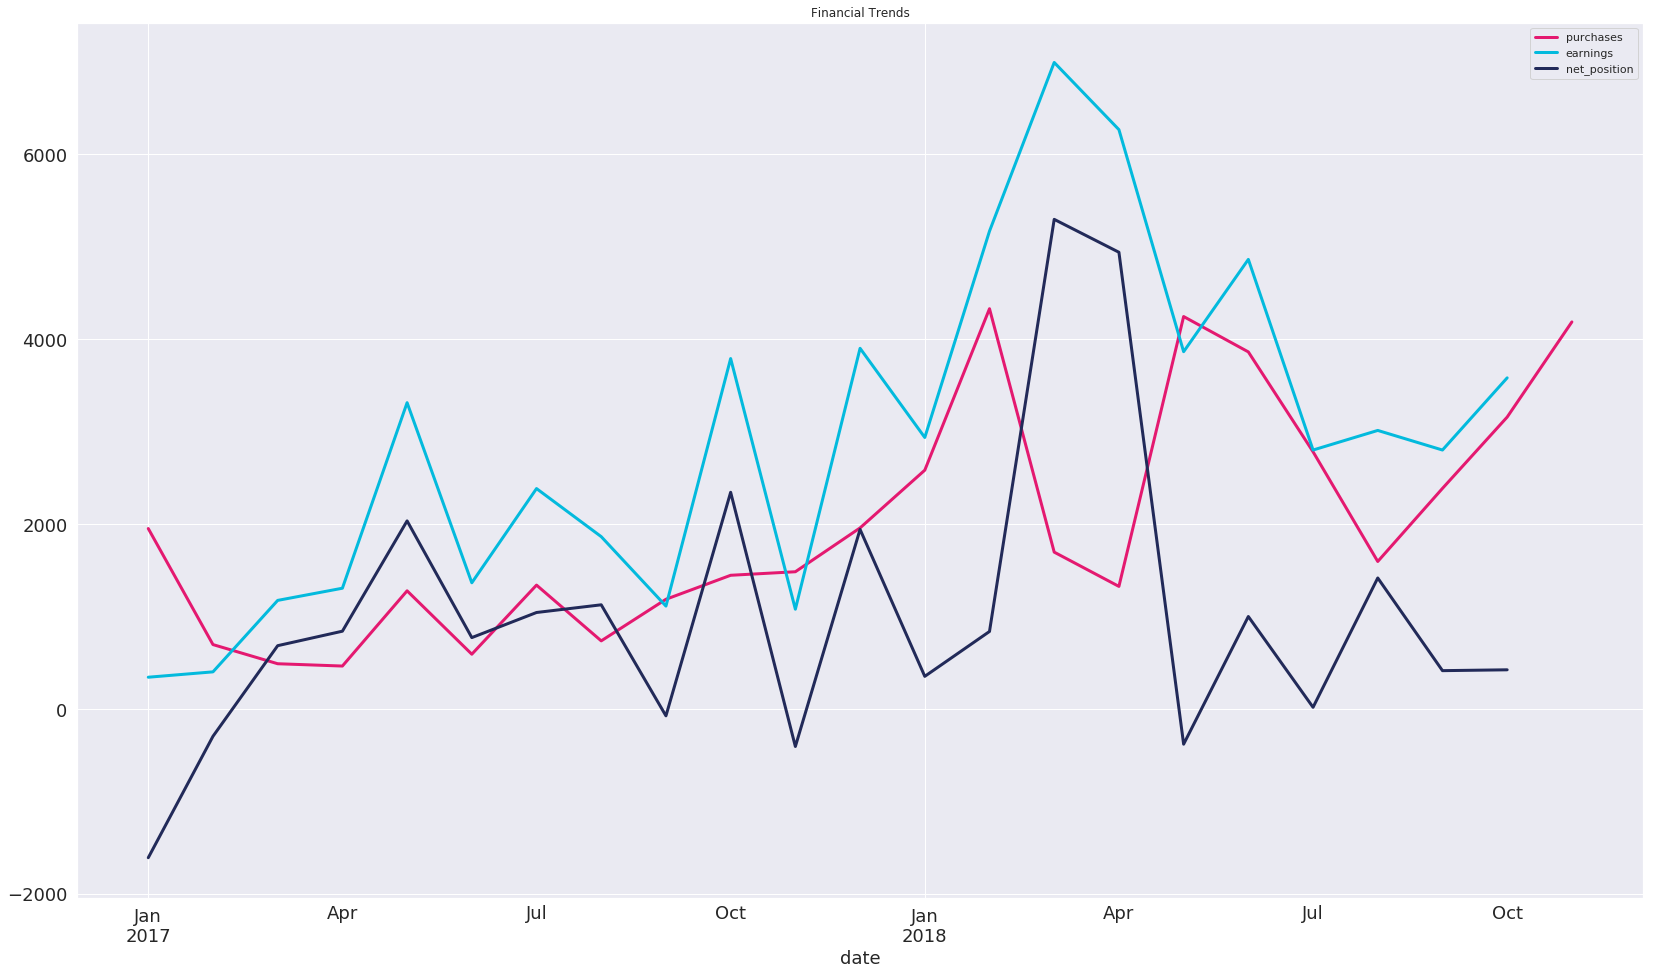

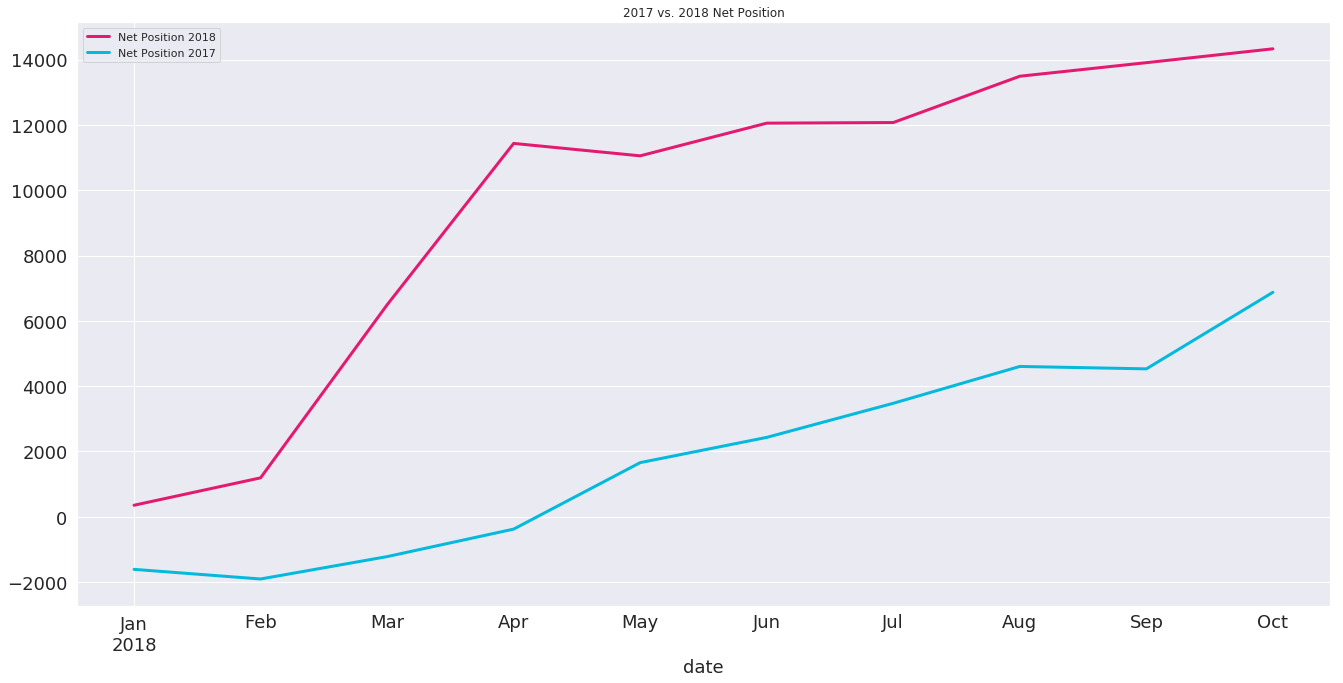

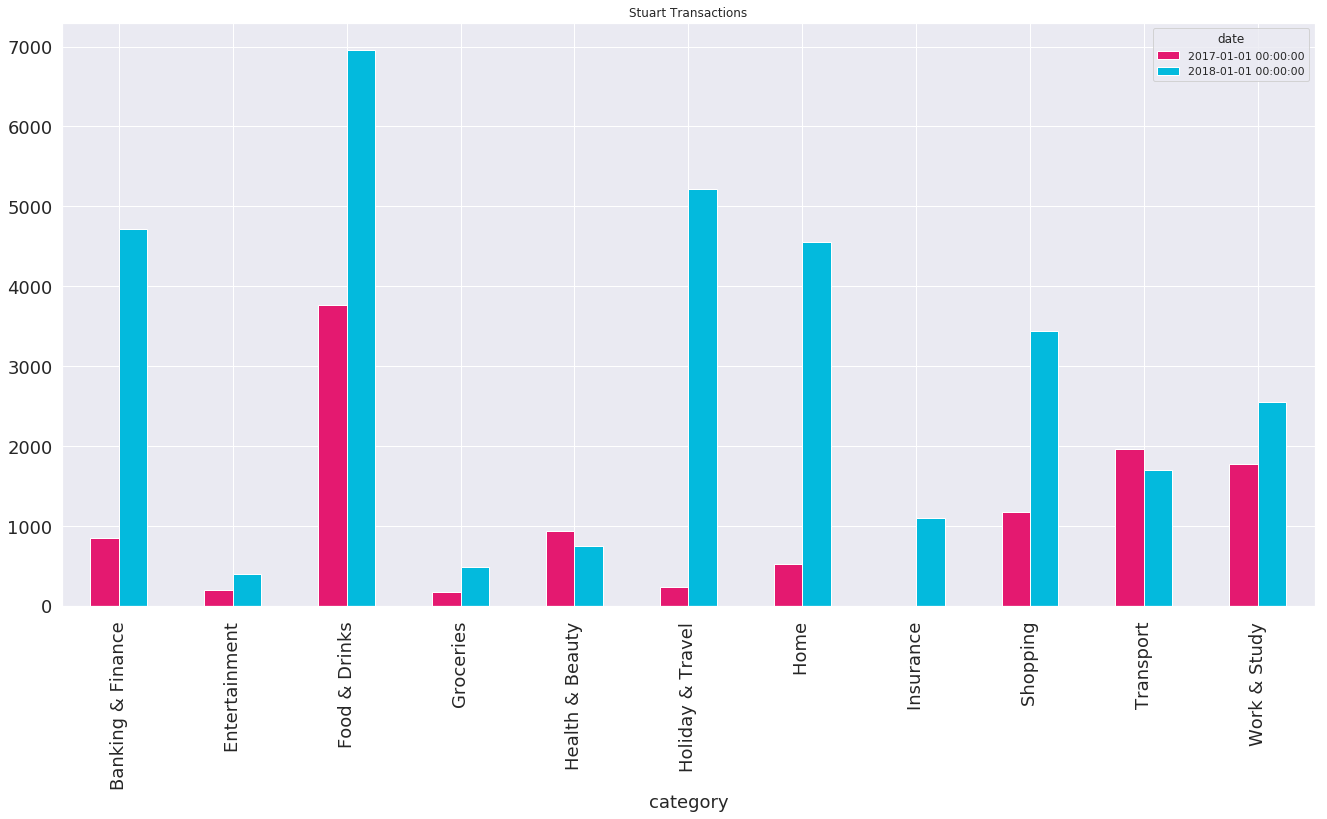

In [193]:
purchases = Purchases.get_purchase_data('./data/pocketbook-export.csv')
earnings = Earnings.get_earnings_data('./data/pocketbook-export.csv')
pf = PlotFinances(purchases, earnings)
pf.plot_trends()
pf.cumsum_plot()
pf.plot_spend_composition()

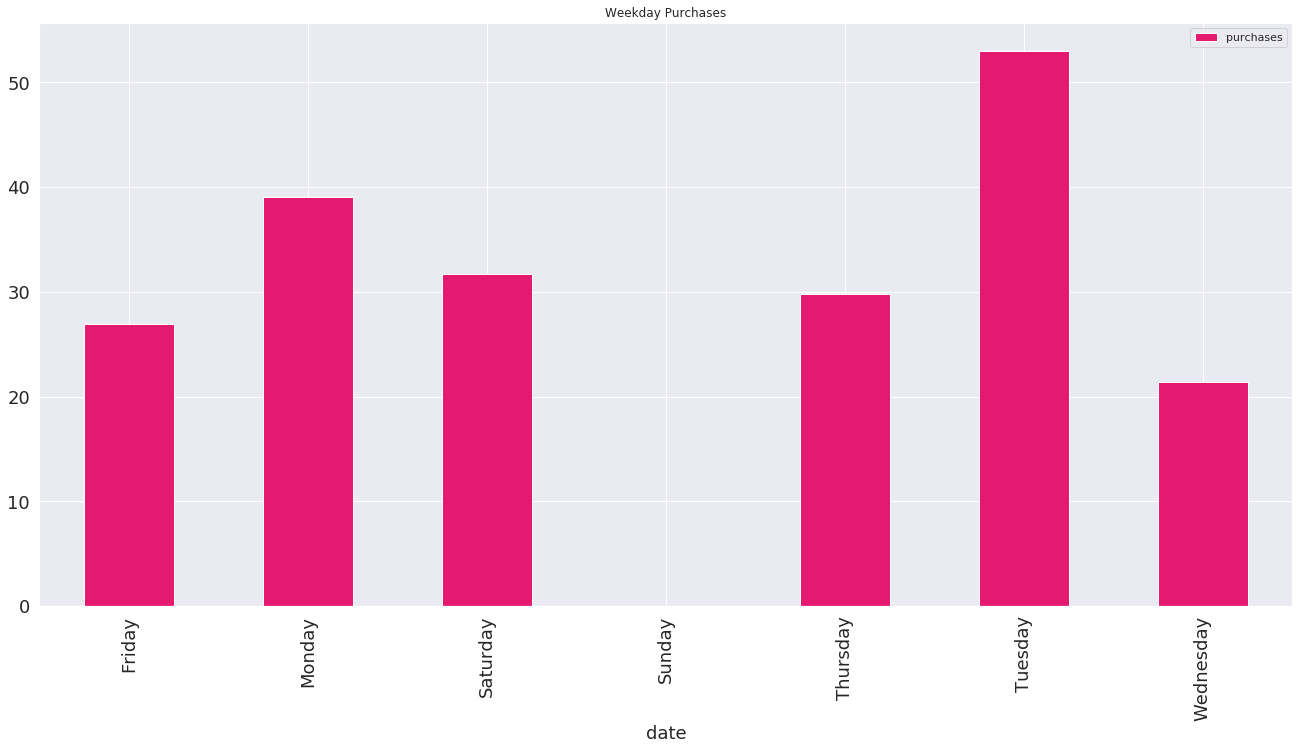

In [128]:
daily_purchases = purchases.set_index('date')['2018':].resample('D').sum().reset_index()
purchase_df = daily_purchases[np.abs(daily_purchases['purchases'] - daily_purchases['purchases'].mean()) <= (1.5*daily_purchases['purchases'].std())]
week_df = purchase_df.groupby(purchase_df['date'].dt.weekday_name).median()
week_df.plot.bar(figsize=(20,10))
plt.title('Weekday Purchases')
plt.show()

# Forecasting with Facebook Prophet

## [About Facebook Prophet](https://research.fb.com/prophet-forecasting-at-scale/)

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

## [Generalized Additive Model (GAM)](https://petolau.github.io/Analyzing-double-seasonal-time-series-with-GAM-in-R/)


Where do the three words or letters come from:
* __M__: A regression model is method a which maps the response (dependent) variable by a set of independent variables.
* __G__: When we want to linearly model a response variable which is not from normal Gaussian distribution, for example, it can be binary (logistic regression) or discrete (Poisson) variable, we can use a generalization of the linear model - Generalized Linear Model (GLM)
* __A__:  The A letter Additive Model, means that the response variable depends linearly on unknown smooth functions. In the other words, the goal is to model the response variable by independent variables, which are in the form of some smooth functions.

GAM Can Be Formally Written As:

$$g(E(y_i)) = \beta_0 + f_1(x_{i1}) + ... + f_p(x_{ip}) + \epsilon_i$$

$$y_i \sim \text{some exponential family distribution}$$

In [172]:
from fbprophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt


# set dateframe and rename columns to prophets required ds and y
purchase_df = purchases[['date', 'purchases']].rename(columns={'date' : 'ds', 'purchases' : 'y'})
purchase_df = purchase_df[np.abs(purchase_df['y']-purchase_df['y'].mean()) <= (1.5*purchase_df['y'].std())]
purchase_df = purchase_df.set_index('ds')[:'2018-10'].resample('M').sum().reset_index()


# instantiate Prophet class and fit data

m = Prophet()
m.fit(purchase_df)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 21.0.


In [173]:
future = m.make_future_dataframe(periods=5, freq='M')
future.tail()

,ds
28,2018-11-30
29,2018-12-31
30,2019-01-31
31,2019-02-28
32,2019-03-31


In [174]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
23,2018-06-30,1379.575604,955.759197,1808.473260
24,2018-07-31,1838.874353,1413.693807,2282.824287
25,2018-08-31,1481.073791,1062.478440,1897.054260
26,2018-09-30,1740.577297,1276.196441,2172.182643
27,2018-10-31,2097.953814,1668.917437,2542.839518
28,2018-11-30,2071.386015,1630.133143,2512.856064
29,2018-12-31,1816.190973,1373.914719,2239.697258
30,2019-01-31,2320.684828,1892.962390,2766.763025
31,2019-02-28,2361.812505,1928.018754,2742.655627
32,2019-03-31,1885.356265,1473.957928,2312.072596


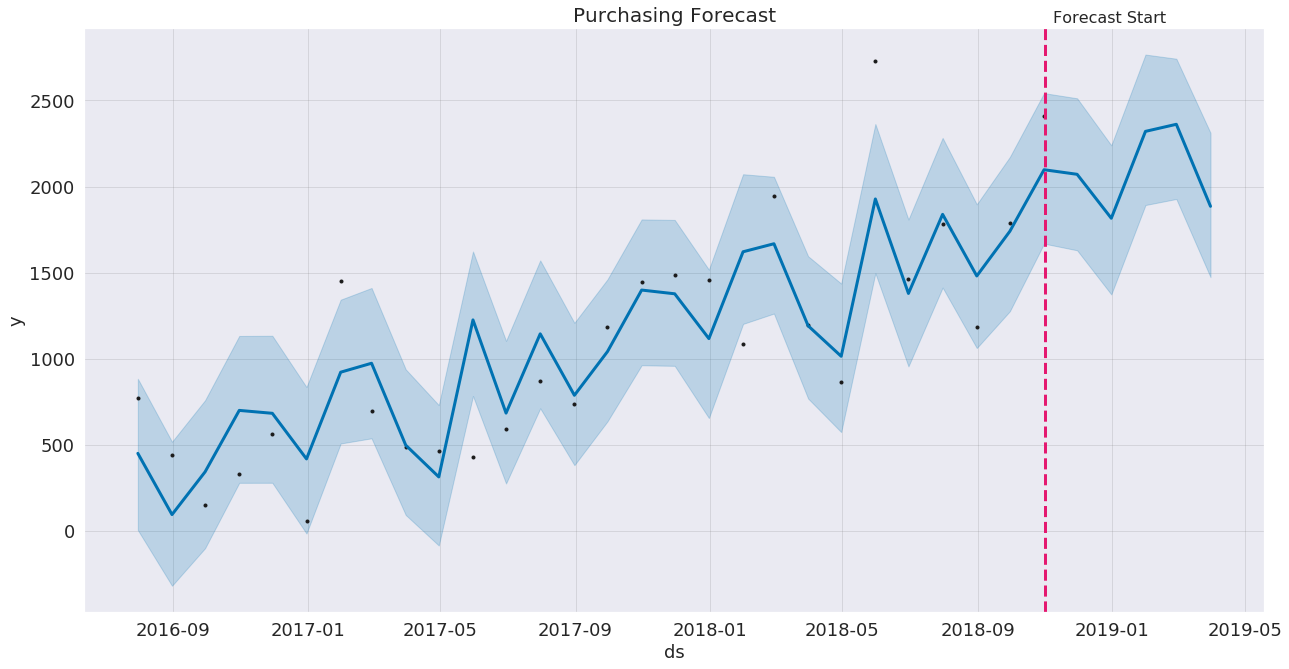

In [217]:
s = m.plot(forecast)
s.set_figheight(10)
s.set_figwidth(20)
plt.axvline(dt.datetime(2018, 11, 1), linestyle='--', label="Forecast")
plt.text(dt.datetime(2018, 11, 8),2950, "Forecast Start", fontsize=16)
plt.title('Purchasing Forecast', fontsize=20)
plt.show()